# Accessing ERDDAP from Python

ERDDAP rich responses and RESTful API is makes it **THE** most convenient way to serve data.

One can build URLs manually or programmatically like:

<small>`https://erddap-uncabled.oceanobservatories.org/uncabled/erddap/tabledap/CP05MOAS-GL336-02-FLORTM000-flort_m_glider_instrument-telemetered-deployment0005-tabledap.csv?ctdgv_m_glider_instrument_sci_water_temp,time&time>=2017-02-10T00:00:00Z`</small>

- server: `https://data.ioos.us/gliders/erddap/`
- protocol: `tabledap`
- dataset_id: `cp_336-20170817T1159`
- variables: `time,latitude,longitude,temperature`
- constraints:
    - `time>=2017-10-11T00:00:00Z`
    - `time<=2017-10-18T00:00:00Z`
    - `latitude>=38.0`
    - `latitude<=41.0`
    - `longitude>=-72.0`
    - `longitude<=-69.0`

In [1]:
from erddapy import ERDDAP

server = 'https://data.ioos.us/gliders/erddap'

dataset_id = 'cp_336-20170817T1159'

constraints = {
    'time>=': '2017-10-11T00:00:00Z',
    'time<=': '2017-10-18T08:16:57Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0
}

depth = 'depth'
salinity = 'salinity'
temperature = 'temperature'

variables = [
  depth,
 'latitude',
 'longitude',
  salinity,
  temperature,
 'time',
]

In [2]:
e = ERDDAP(
    server=server,
    dataset_id=dataset_id,
    constraints=constraints,
    variables=variables,
    protocol='tabledap',
    response='mat',
)

print(e.get_download_url())

https://data.ioos.us/gliders/erddap/tabledap/cp_336-20170817T1159.mat?depth,latitude,longitude,salinity,temperature,time&time>=1507680000.0&time<=1508314617.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


# Obtaining the data

There are a few methods to obtain the data with *to_pandas()* and *to_xarray()*:

In [3]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

In [4]:
df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2017-10-11 00:20:27,0.426711,39.84344,-70.497854,34.911377,21.2208
2017-10-11 00:20:27,1.438906,39.84344,-70.497854,34.911910,21.2250
2017-10-11 00:20:27,5.477711,39.84344,-70.497854,34.912373,21.2276
2017-10-11 00:20:27,14.319142,39.84344,-70.497854,35.077354,21.1920
2017-10-11 00:20:27,25.095050,39.84344,-70.497854,35.143433,21.1202


# Let's plot the data

# Exploring an ERDDAP server

In [5]:
from erddapy import ERDDAP


e = ERDDAP(server='https://data.ioos.us/gliders/erddap')

In [6]:
import pandas as pd


df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))

In [7]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 432 tabledap, 0 griddap, and 0 wms endpoints.'

# ERDDAP Advanced Search

Let's narrow the search area, time span, and look for *sea_water_temperature* only.

In [8]:
bbox = [-72.0, -69.0, 38.0, 41.0]

min_time = '2018-02-01T00:00:00Z'
max_time = '2018-02-08T00:00:00Z'

kw = {
    'standard_name': 'sea_water_temperature',
    'search_for': 'glider',
    'min_lon': bbox[0],
    'max_lon': bbox[1],
    'min_lat': bbox[2],
    'max_lat': bbox[3],
    'min_time': min_time,
    'max_time': max_time,
    'cdm_data_type': 'trajectory'
}

In [9]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

msg = 'Found {} Glider Datasets:\n\n{}'.format
print(msg(len(gliders), '\n'.join(gliders)))

Found 5 Glider Datasets:

allrutgersGliders
cp_336-20180126T0000
cp_339-20180126T0000
cp_380-20180126T0000
sp066-20171129T1616


With the Dataset IDs we can explore the metadata with the *get_info_url*

In [10]:
print(gliders[0])

info_url = e.get_info_url(dataset_id=gliders[0], response='csv')
info = pd.read_csv(info_url)

info.head()

allrutgersGliders


,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgment,String,This deployment supported by funding from the ...
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,contributor_name,String,"Josh Kohut, Dave Aragon, Chip Haldeman, Nicole..."


In [11]:
cdm_profile_variables = info.loc[
    info['Attribute Name'] == 'cdm_profile_variables', 'Value'
]

print(''.join(cdm_profile_variables))

profile_id, time, latitude, longitude, time_uv, lat_uv, lon_uv, u, v


# Selecting variables by attributes

In [12]:
e.get_var_by_attr(
    dataset_id='cp_336-20180126T0000',
    standard_name='sea_water_temperature'
)

['temperature']

# Easy to use CF conventions standards

In [13]:

t_vars = [
    e.get_var_by_attr(
        dataset_id=glider, standard_name='sea_water_temperature'
    )[0] for glider in gliders
]
t_vars

['temperature', 'temperature', 'temperature', 'temperature', 'temperature']

In [14]:
s_vars = [
    e.get_var_by_attr(
        dataset_id=glider, standard_name='sea_water_practical_salinity'
    )[0] for glider in gliders
]
s_vars

['salinity', 'salinity', 'salinity', 'salinity', 'salinity']

In [15]:
d_vars = [
    e.get_var_by_attr(
        dataset_id=glider, standard_name='sea_water_pressure'
    )[0] for glider in gliders
]
d_vars

['pressure', 'pressure', 'pressure', 'pressure', 'pressure']

In [16]:
# FIX: should not really assume that variables are the same for each dataset
depth = d_vars[0]
salinity = s_vars[0]
temperature = t_vars[0]


# Putting everything together

In [17]:
from requests.exceptions import HTTPError

constraints = {
    'time>=': min_time,
    'time<=': max_time,
    'longitude>=': bbox[0],
    'longitude<=': bbox[1],
    'latitude>=': bbox[2],
    'latitude<=': bbox[3]
}

def download_csv(url):
    return pd.read_csv(
        url, index_col='time', parse_dates=True, skiprows=[1]
    )

dfs = {}
for glider in gliders:
    try:
        download_url = e.get_download_url(
            dataset_id=glider,
            protocol='tabledap',
            variables=['time', 'latitude', 'longitude', depth, salinity, temperature],
            response='csv',
            constraints=constraints
        )
    except HTTPError:
        print('Failed to download {}'.format(glider))
        continue
    dfs.update({glider: download_csv(download_url)})

Failed to download allrutgersGliders
Failed to download sp066-20171129T1616


In [18]:
import numpy as np

for glider in dfs.keys():
    dfs[glider].loc[dfs[glider][salinity] <= .1, salinity] = np.NaN
    dfs[glider].loc[dfs[glider][temperature] <= .1, temperature] = np.NaN

In [19]:
import folium

zoom_start = 7
lon = (bbox[0] + bbox[1]) / 2
lat = (bbox[2] + bbox[3]) / 2
m = folium.Map(width='100%', height='100%',
               location=[lat, lon], zoom_start=zoom_start)

url = 'https://gis.ngdc.noaa.gov/arcgis/services/gebco08_hillshade/MapServer/WMSServer'
w = folium.WmsTileLayer(
    url,
    name='GEBCO Bathymetry',
    fmt='image/png',
    layers='GEBCO_08 Hillshade',
    attr='GEBCO',
    overlay=True,
    transparent=True)

w.add_to(m)

colors = ['orange','pink','yellow']

k=0
for glider, df in dfs.items():

    line = folium.PolyLine(locations=list(zip(df['latitude'],df['longitude'])),
                           color=colors[k],
                           weight=8,
                           opacity=0.6,
                           popup=glider[:22]).add_to(m)
    k = k+1

m

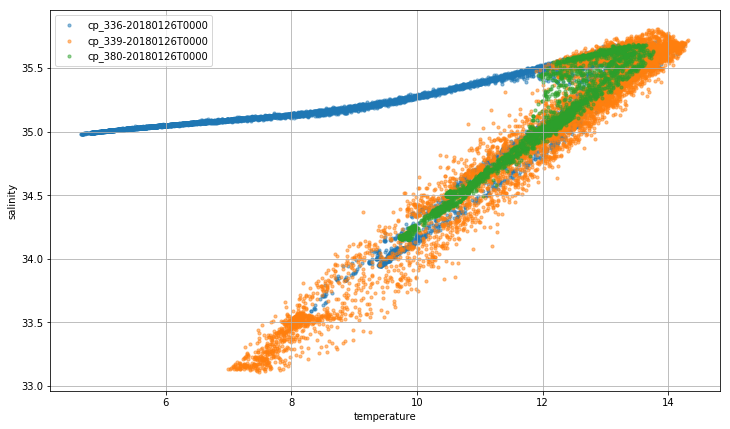

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def glider_scatter(df, ax, glider):
    ax.scatter(df[temperature], df[salinity],
               s=10, alpha=0.5, label=glider)
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)
leg = ax.legend()

## Plot one of the glider transects

In [21]:
df = next(iter(dfs.values()))

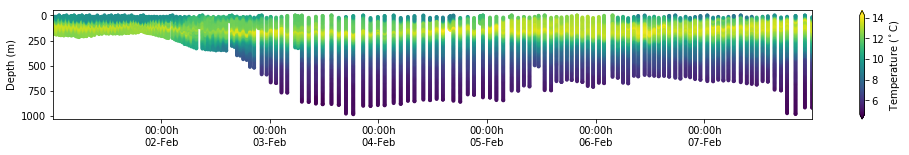

In [22]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df[depth], s=15, c=df[temperature], marker='o', edgecolor='none')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');